In [1]:
"""
IMPORTS
"""
# Necessities
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
torch.cuda.is_available()

# Continuum
from continuum import Permutations
from continuum.datasets import MNIST


In [2]:
# Constants
BATCH_SIZE = 64

### MNIST: Digits recognition (Basic CNN)

In [3]:
# Use the Permuted MNIST scenario from Continuum
train_scenario = Permutations(
    MNIST(data_path="~/Datasets/", download=True, train=True),
    nb_tasks=5,
    seed=1,
    shared_label_space=True)

test_scenario = Permutations(
    MNIST(data_path="~/Datasets/", download=True, train=False),
    nb_tasks=5,
    seed=1,
    shared_label_space=True)

In [4]:
# Efficiently load the datasets using DataLoader 
trainloader_0 = torch.utils.data.DataLoader(train_scenario[0], batch_size=BATCH_SIZE, shuffle=True)
testloader_0 = torch.utils.data.DataLoader(test_scenario[0], batch_size=BATCH_SIZE, shuffle=False)

# Fetch training batch images, labels, and taskIDs
images, labels, taskID = next(iter(trainloader_0))

print('X_train size: ', images.shape, 'and type: ', labels.dtype)
print('y_train size: ', labels.shape, 'and type: ', labels.dtype)

X_train size:  torch.Size([64, 1, 28, 28]) and type:  torch.int64
y_train size:  torch.Size([64]) and type:  torch.int64


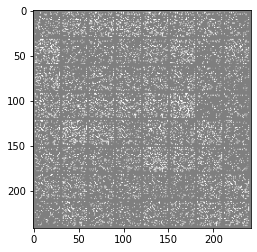

tensor([9, 3, 2, 7, 6, 7, 4, 9, 0, 6, 1, 9, 5, 2, 1, 6, 2, 4, 2, 9, 3, 9, 5, 2,
        8, 3, 3, 5, 6, 9, 1, 9, 8, 4, 8, 5, 0, 7, 8, 6, 3, 6, 4, 5, 3, 9, 9, 9,
        0, 0, 2, 7, 8, 5, 8, 2, 5, 2, 2, 7, 4, 5, 8, 6])


In [8]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [5]:
use_cuda = True
# Make sure GPU is available
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

In [6]:
# Define model
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(9*9*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # use x.shape to check the current size
#         print (x.shape)
        x = F.max_pool2d(x, 2, 1)
#         print (x.shape)
        x = F.relu(self.conv2(x))
#         print (x.shape)
        x = F.max_pool2d(x, 2, 2)
#         print (x.shape)
        x = x.view(-1, 9*9*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

net = LeNet()

In [17]:
def train(model, device, optimizer, epoch, trainloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Retrieve inputs
        inputs, labels, taskID = data
        # Send inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            # Retrieve inputs
            inputs, labels, taskID = data
            # Send inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += criterion(outputs, labels)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_loss /= total
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, total, 100. * (correct/total)))
#     return 100. * correct / total

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [10]:
# Instantiate model and start training
model = net.to(device)
for epoch in range(0, 3):
    train(model, device, optimizer, epoch, trainloader_0)
    test(model, device, testloader_0)

Train Epoch: 0 	Loss: 0.563420
Test set: Average loss: 0.0060, Accuracy: 8816/10000 (88%)

Train Epoch: 1 	Loss: 0.254116
Test set: Average loss: 0.0036, Accuracy: 9315/10000 (93%)

Train Epoch: 2 	Loss: 0.227163
Test set: Average loss: 0.0030, Accuracy: 9428/10000 (94%)



### Apply the CNN to solve a new task (permuted MNIST)

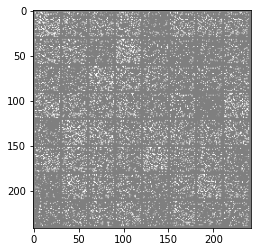

tensor([8, 6, 0, 2, 5, 9, 8, 0, 8, 8, 3, 0, 1, 1, 8, 5, 9, 2, 2, 8, 7, 1, 1, 2,
        2, 3, 2, 4, 4, 1, 1, 0, 9, 8, 8, 7, 2, 8, 9, 2, 3, 6, 7, 6, 0, 7, 7, 4,
        7, 2, 7, 6, 5, 7, 5, 5, 7, 4, 6, 8, 4, 8, 5, 6])


In [9]:
# Efficiently load another task using DataLoader 
trainloader_1 = torch.utils.data.DataLoader(train_scenario[1], batch_size=BATCH_SIZE, shuffle=True)
testloader_1 = torch.utils.data.DataLoader(test_scenario[1], batch_size=BATCH_SIZE, shuffle=False)

# Fetch training batch images, labels, and taskIDs
images, labels, taskID = next(iter(trainloader_1))

# Show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [12]:
print('Testing on first task:')
test(model, device, testloader_0)

print('Testing on second task:')
test(model, device, testloader_1)

Testing on first task:
Test set: Average loss: 0.0030, Accuracy: 9428/10000 (94%)

Testing on second task:
Test set: Average loss: 0.0490, Accuracy: 790/10000 (8%)



Our model clearly doesn't generalize to the permuted task. Can we finetune our model with permuted training data to improve it's results?

In [13]:
for epoch in range(0, 3):
    train(model, device, optimizer, epoch, trainloader_1)
    test(model, device, testloader_1)

Train Epoch: 0 	Loss: 0.849513
Test set: Average loss: 0.0100, Accuracy: 7965/10000 (80%)

Train Epoch: 1 	Loss: 0.881636
Test set: Average loss: 0.0070, Accuracy: 8572/10000 (86%)

Train Epoch: 2 	Loss: 0.302737
Test set: Average loss: 0.0060, Accuracy: 8787/10000 (88%)



In [14]:
print('Testing on first task:')
test(model, device, testloader_0)

print('Testing on second task:')
test(model, device, testloader_1)

Testing on first task:
Test set: Average loss: 0.1608, Accuracy: 1928/10000 (19%)

Testing on second task:
Test set: Average loss: 0.0060, Accuracy: 8787/10000 (88%)



WAIT. It forgot how to perform the first task! This is due to **Catastrophic Forgetting**. 

What if we added a third task? According to Catastrophic Forgetting, training the model on the third task will cause it to perform poorly on the first two. Let's see.

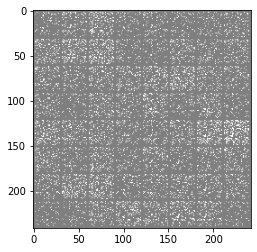

tensor([1, 9, 8, 3, 4, 1, 6, 0, 2, 8, 0, 2, 9, 4, 9, 4, 9, 3, 5, 2, 7, 0, 0, 4,
        0, 1, 6, 3, 2, 4, 6, 5, 0, 8, 0, 4, 7, 2, 9, 8, 0, 6, 2, 9, 4, 4, 4, 4,
        1, 0, 3, 1, 1, 3, 9, 2, 1, 2, 5, 7, 9, 6, 8, 1])


In [10]:
# Efficiently load another task using DataLoader 
trainloader_2 = torch.utils.data.DataLoader(train_scenario[2], batch_size=BATCH_SIZE, shuffle=True)
testloader_2 = torch.utils.data.DataLoader(test_scenario[2], batch_size=BATCH_SIZE, shuffle=False)

# Fetch training batch images, labels, and taskIDs
images, labels, taskID = next(iter(trainloader_2))

# Show images
imshow(torchvision.utils.make_grid(images))
print(labels)

Since the model was last trained on the second task, it should only perform well on that one.

In [16]:
print('Testing on first task:')
test(model, device, testloader_0)

print('Testing on second task:')
test(model, device, testloader_1)

print('Testing on third task:')
test(model, device, testloader_2)

Testing on first task:
Test set: Average loss: 0.1608, Accuracy: 1928/10000 (19%)

Testing on second task:
Test set: Average loss: 0.0060, Accuracy: 8787/10000 (88%)

Testing on third task:
Test set: Average loss: 0.0836, Accuracy: 740/10000 (7%)



Now let's train the model using the training data from the third task.

In [17]:
for epoch in range(0, 3):
    train(model, device, optimizer, epoch, trainloader_2)
    test(model, device, testloader_2)

Train Epoch: 0 	Loss: 0.678172
Test set: Average loss: 0.0078, Accuracy: 8437/10000 (84%)

Train Epoch: 1 	Loss: 0.239924
Test set: Average loss: 0.0057, Accuracy: 8889/10000 (89%)

Train Epoch: 2 	Loss: 0.230767
Test set: Average loss: 0.0046, Accuracy: 9089/10000 (91%)



If our hypothesis is correct, the model should only perform well on the third and final task.

In [18]:
print('Testing on first task:')
test(model, device, testloader_0)

print('Testing on second task:')
test(model, device, testloader_1)

print('Testing on third task:')
test(model, device, testloader_2)

Testing on first task:
Test set: Average loss: 0.1597, Accuracy: 2301/10000 (23%)

Testing on second task:
Test set: Average loss: 0.0432, Accuracy: 2618/10000 (26%)

Testing on third task:
Test set: Average loss: 0.0046, Accuracy: 9089/10000 (91%)



## CL Strategies: Rehearsal

In order to prevent (or reduce) catastrophic forgetting, we can keep all or some samples from previously encountered tasks and mix them in the data of the current task. There is an very clear tradeoff between the amount of data we keep and memory requirements. Testing performance would be optimized if we could keep all previously seen samples at the expense of much larger memory requirements.

In [11]:
task_1 = [trainloader_0, testloader_0]
task_2 = [trainloader_1, testloader_1]
task_3 = [trainloader_2, testloader_2]
tasks = [task_1, task_2, task_3]

##, np.unique()taskID, np.unique()taskID, np.unique()taskID, np.unique()taskID, np.unique()taskID, np.unique()taskID, np.unique()taskID, np.unique()taskID CL Strategies: EWC

In [12]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [13]:
model = LeNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

At the end of each task, compute the Fisher information for each weight:

In [14]:
def on_task_update(task_id, trainloader):
    
    model.train()
    optimizer.zero_grad()
    
    for i, data in enumerate(trainloader, 0):
        x, y, _ = next(iter(trainloader))
    
        # Accumulating gradients
        for start in range(0, len(y)-1, 256):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()

        fisher_dict[task_id] = {}
        optpar_dict[task_id] = {}

    # Calculate Fisher using accumulated gradients
    for name, param in model.named_parameters():
        optpar_dict[task_id][name] = param.data.clone()
        fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

Modify our train function to include the new regularization loss:

In [15]:
def train_ewc(model, device, task_id, optimizer, epoch, trainloader):
    
    model.train()
    
    for i, data in enumerate(trainloader, 0):
        images, labels, taskID = data
        for start in range(0, len(labels)-1, 256):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = F.cross_entropy(output, labels)
            
        for task in range(task_id):
            for name, param in model.named_parameters():
                fisher = fisher_dict[task][name]
                optpar = optpar_dict[task][name]
                loss += (fisher * (optpar-param).pow(2)).sum() * ewc_lambda
        
        loss.backward()
        optimizer.step()
#         print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [18]:
ewc_accs = []
for id, task in enumerate(tasks):
    avg_acc = 0
    print("------------------")
    print("TRAINING ON TASK: ", id)
    
    trainloader, testloader = task
    
    for epoch in range(1,3):
        train_ewc(model, device, id, optimizer, epoch, trainloader)
    on_task_update(id, trainloader)
    
    # Test
    print('Testing on first task:')
    test(model, device, testloader_0)

    print('Testing on second task:')
    test(model, device, testloader_1)

    print('Testing on third task:')
    test(model, device, testloader_2)

------------------
TRAINING ON TASK:  0
Testing on first task:


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [65]:
for id, task in enumerate(tasks):
    print("TRAINING ON TASK: ", id)
    trainloader, testloader = task
    _, _, taskID = next(iter(trainloader))
    print(np.unique(taskID))

TRAINING ON TASK:  0
[0.]
TRAINING ON TASK:  1
[1.]
TRAINING ON TASK:  2
[2.]
